# ACCESS Bottom temp

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

<Client: 'tcp://127.0.0.1:37273' processes=28 threads=28, memory=125.19 GiB>

In [4]:
#Importing data

pathsC = np.sort(glob.glob('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/outpu*/ocean/ocean.nc'))
pathsM = np.sort(glob.glob('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath_sofia_ssp126/*/ocean/ocean.nc'))

In [5]:
## Creating shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [6]:
depth = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['ht']
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom5')

In [7]:
#Time variant variables
def preprocess(ds):
    ds = ds['temp'].where(shelf_mask == 1)
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [8]:
#Time slicing
cont = cont.sel(time=slice('1910-01-01','1919-12-31'))
melt = melt.sel(time=slice('1910-01-01','1919-12-31'))

In [9]:
#Time invariant variables
areaC = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['area_t']
areaM = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath_sofia_ssp126/output040/ocean/ocean_grid.nc')['area_t']

In [10]:
## Selecting temperature
# This is already in conservative temperature so don't need to convert
tempC = cont['temp']
tempM = melt['temp']

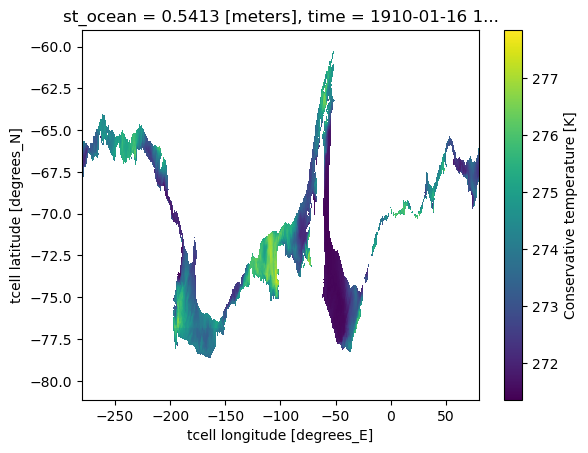

In [11]:
# Checking shelf mask
tempC.isel(st_ocean=0).isel(time=0).plot()

### Creating the regions

In [12]:
## Weddell Sea
# Saved as _W
lat_slice_W = slice(-78,-71)
lon_slice_W = slice(-64.95,-44.95)

## Ross Sea
# Saved as _R
lat_slice_R = slice(-78,-71.5)
lon_slice_R = slice(-200,-175)

## Adelie Coast
# Saved as _A
lat_slice_A = slice(-69,-64.5)
lon_slice_A = slice(45,79)

## Prydz Bay
# Saved as _P
lat_slice_P = slice(-69,-65)
lon_slice_P = slice(-235,-205)

#### Bottom mask

In [13]:
bottom_mask_tempC = tempC.where(~np.isfinite(tempC.shift({'st_ocean': -1})))
bottom_mask_tempC = ~np.isnan(bottom_mask_tempC)

In [14]:
bottom_mask_tempM = tempM.where(~np.isfinite(tempM.shift({'st_ocean': -1})))
bottom_mask_tempM = ~np.isnan(bottom_mask_tempM)

In [15]:
# Checking size
bottom_mask_tempC

<xarray.DataArray 'temp' (time: 120, st_ocean: 75, yt_ocean: 510, xt_ocean: 3600)> Size: 17GB
dask.array<invert, shape=(120, 75, 510, 3600), dtype=bool, chunksize=(2, 38, 270, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -81.11 -81.07 -81.02 ... -59.08 -59.03
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 960B 1910-01-16 12:00:00 ... 1919-12-16 12:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 7MB nan nan nan ... 79.75 79.85 79.95
    geolat_t  (yt_ocean, xt_ocean) float32 7MB nan nan nan ... -59.03 -59.03
Attributes:
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_conservative_temperature

## Time series

In [16]:
# Correcting area
areaC_corr = areaC*(tempC.isel(time=0,st_ocean=0)*0 + 1)
areaM_corr = areaM*(tempM.isel(time=0,st_ocean=0)*0 + 1)

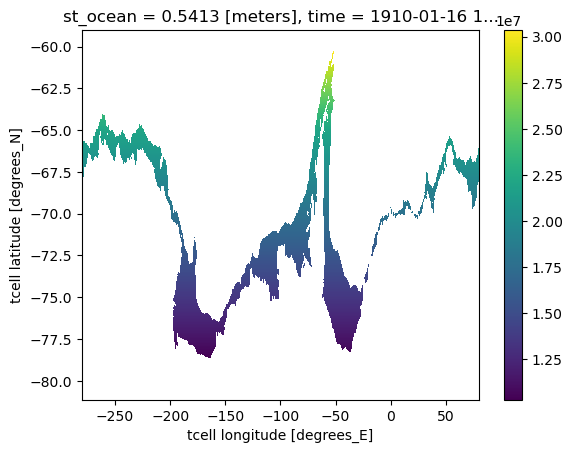

In [17]:
areaC_corr.plot()

In [18]:
# Taking only the bottom 
bottemp_cont = tempC.where(bottom_mask_tempC).sum(dim='st_ocean')
bottemp_pert = tempM.where(bottom_mask_tempM).sum(dim='st_ocean')

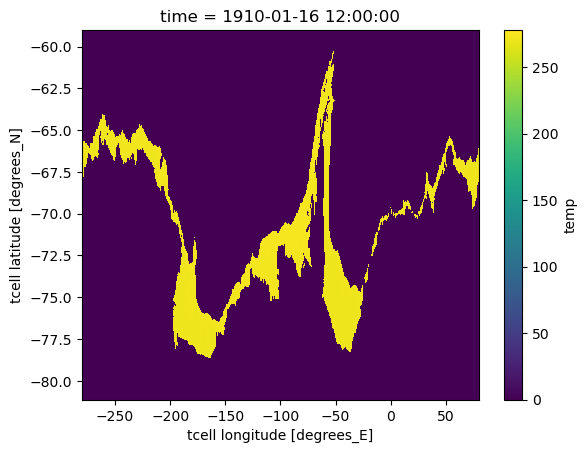

In [21]:
bottemp_cont.isel(time=0).plot()

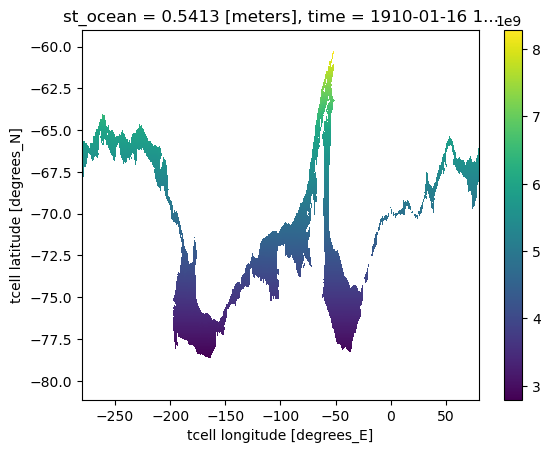

In [22]:
(areaC_corr*bottemp_cont.isel(time=0)).plot()

In [23]:
# Restricting to regions
bottemp_cont_W = bottemp_cont.sel(yt_ocean=lat_slice_W,xt_ocean=lon_slice_W)
bottemp_pert_W = bottemp_pert.sel(yt_ocean=lat_slice_W,xt_ocean=lon_slice_W)

bottemp_cont_R = bottemp_cont.sel(yt_ocean=lat_slice_R,xt_ocean=lon_slice_R)
bottemp_pert_R = bottemp_pert.sel(yt_ocean=lat_slice_R,xt_ocean=lon_slice_R)

bottemp_cont_A = bottemp_cont.sel(yt_ocean=lat_slice_A,xt_ocean=lon_slice_A)
bottemp_pert_A = bottemp_pert.sel(yt_ocean=lat_slice_A,xt_ocean=lon_slice_A)

bottemp_cont_P = bottemp_cont.sel(yt_ocean=lat_slice_P,xt_ocean=lon_slice_P)
bottemp_pert_P = bottemp_pert.sel(yt_ocean=lat_slice_P,xt_ocean=lon_slice_P)

In [24]:
# Spatial averages
bottemp_cont_W_time = (areaC_corr * bottemp_cont_W).sum(['xt_ocean', 'yt_ocean']) / areaC_corr.sel(yt_ocean=lat_slice_W,xt_ocean=lon_slice_W).sum(['xt_ocean', 'yt_ocean'])
bottemp_pert_W_time = (areaM_corr * bottemp_pert_W).sum(['xt_ocean', 'yt_ocean']) / areaM_corr.sel(yt_ocean=lat_slice_W,xt_ocean=lon_slice_W).sum(['xt_ocean', 'yt_ocean'])

bottemp_cont_R_time = (areaC_corr * bottemp_cont_R).sum(['xt_ocean', 'yt_ocean']) / areaC_corr.sel(yt_ocean=lat_slice_R,xt_ocean=lon_slice_R).sum(['xt_ocean', 'yt_ocean'])
bottemp_pert_R_time = (areaM_corr * bottemp_pert_R).sum(['xt_ocean', 'yt_ocean']) / areaM_corr.sel(yt_ocean=lat_slice_R,xt_ocean=lon_slice_R).sum(['xt_ocean', 'yt_ocean'])

bottemp_cont_A_time = (areaC_corr * bottemp_cont_A).sum(['xt_ocean', 'yt_ocean']) / areaC_corr.sel(yt_ocean=lat_slice_A,xt_ocean=lon_slice_A).sum(['xt_ocean', 'yt_ocean'])
bottemp_pert_A_time = (areaM_corr * bottemp_pert_A).sum(['xt_ocean', 'yt_ocean']) / areaM_corr.sel(yt_ocean=lat_slice_A,xt_ocean=lon_slice_A).sum(['xt_ocean', 'yt_ocean'])

bottemp_cont_P_time = (areaC_corr * bottemp_cont_P).sum(['xt_ocean', 'yt_ocean']) / areaC_corr.sel(yt_ocean=lat_slice_P,xt_ocean=lon_slice_P).sum(['xt_ocean', 'yt_ocean'])
bottemp_pert_P_time = (areaM_corr * bottemp_pert_P).sum(['xt_ocean', 'yt_ocean']) / areaM_corr.sel(yt_ocean=lat_slice_P,xt_ocean=lon_slice_P).sum(['xt_ocean', 'yt_ocean'])

In [25]:
# Check shape
bottemp_cont_W_time

<xarray.DataArray (time: 120)> Size: 480B
dask.array<truediv, shape=(120,), dtype=float32, chunksize=(2,), chunktype=numpy.ndarray>
Coordinates:
    st_ocean  float64 8B 0.5413
  * time      (time) object 960B 1910-01-16 12:00:00 ... 1919-12-16 12:00:00

In [26]:
bottemp_cont_W_time = bottemp_cont_W_time.load()
bottemp_pert_W_time = bottemp_pert_W_time.load()

In [27]:
bottemp_cont_R_time = bottemp_cont_R_time.load()
bottemp_pert_R_time = bottemp_pert_R_time.load()

In [28]:
bottemp_cont_A_time = bottemp_cont_A_time.load()
bottemp_pert_A_time = bottemp_pert_A_time.load()

In [29]:
bottemp_cont_P_time = bottemp_cont_P_time.load()
bottemp_pert_P_time = bottemp_pert_P_time.load()

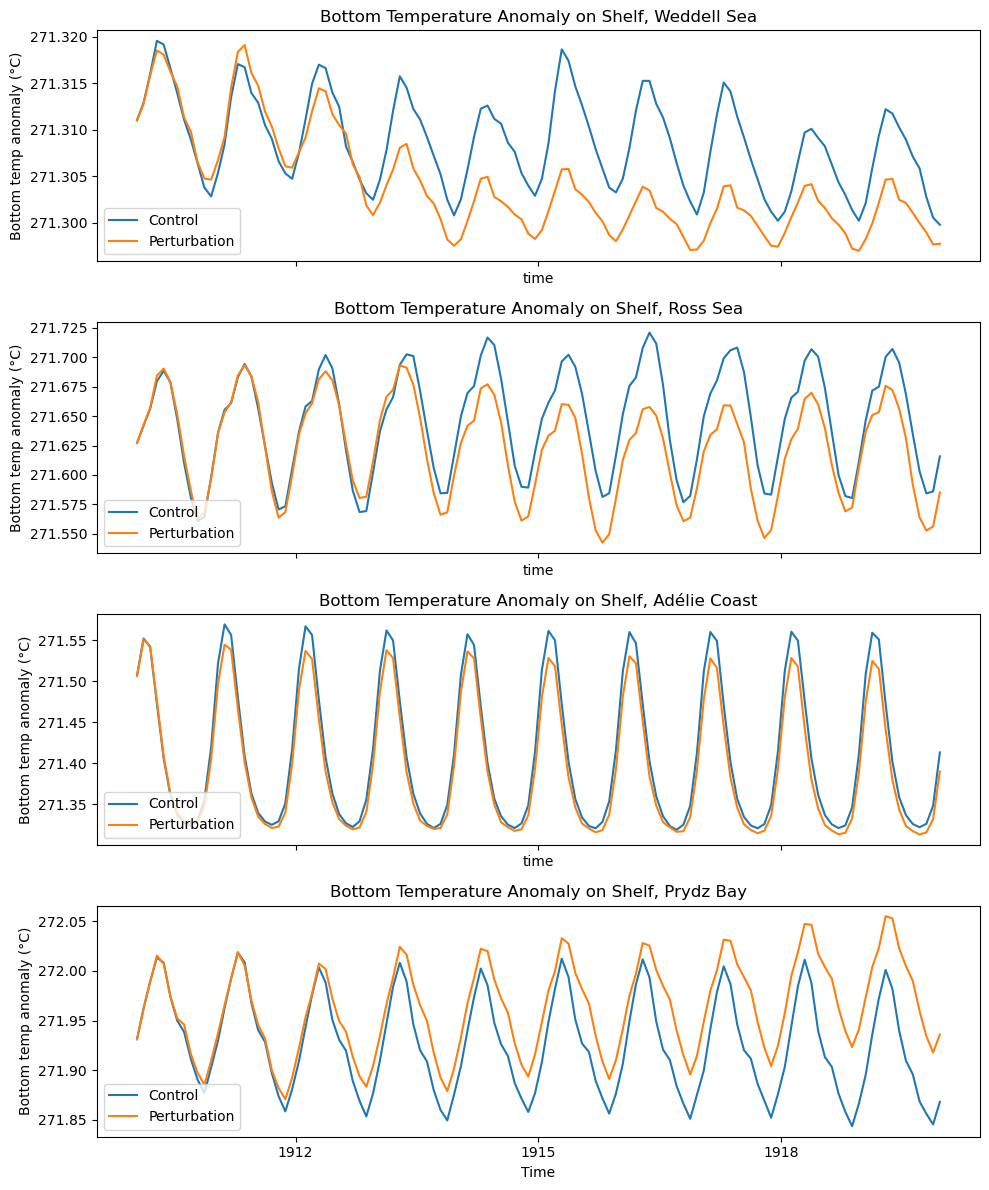

In [30]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(
    nrows=4, ncols=1,
    sharex=True, figsize=(10, 12)
)

# First subplot: W_time
bottemp_cont_W_time.plot(ax=axes[0], label="Control")
bottemp_pert_W_time.plot(ax=axes[0], label="Perturbation")
axes[0].set_ylabel("Bottom temp anomaly (°C)")
axes[0].legend(loc="lower left")
axes[0].set_title("Bottom Temperature Anomaly on Shelf, Weddell Sea")

# Second subplot: R_time
bottemp_cont_R_time.plot(ax=axes[1], label="Control")
bottemp_pert_R_time.plot(ax=axes[1], label="Perturbation")
axes[1].set_ylabel("Bottom temp anomaly (°C)")
axes[1].legend(loc="lower left")
axes[1].set_title("Bottom Temperature Anomaly on Shelf, Ross Sea")

# Third subplot: A_time
bottemp_cont_A_time.plot(ax=axes[2], label="Control")
bottemp_pert_A_time.plot(ax=axes[2], label="Perturbation")
axes[2].set_ylabel("Bottom temp anomaly (°C)")
axes[2].legend(loc="lower left")
axes[2].set_title("Bottom Temperature Anomaly on Shelf, Adélie Coast")

# Fourth subplot: P_time
bottemp_cont_P_time.plot(ax=axes[3], label="Control")
bottemp_pert_P_time.plot(ax=axes[3], label="Perturbation")
axes[3].set_ylabel("Bottom temp anomaly (°C)")
axes[3].legend(loc="lower left")
axes[3].set_title("Bottom Temperature Anomaly on Shelf, Prydz Bay")

# Common X‑axis label
axes[-1].set_xlabel("Time")

# Adjust layout
plt.tight_layout()
plt.show()

In [31]:
bottemp_anom_W_time = bottemp_pert_W_time - bottemp_cont_W_time
bottemp_anom_W_time = bottemp_anom_W_time.load()

In [32]:
bottemp_anom_W_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_W_access.nc')

In [33]:
bottemp_anom_R_time = bottemp_pert_R_time - bottemp_cont_R_time
bottemp_anom_R_time = bottemp_anom_R_time.load()

In [34]:
bottemp_anom_R_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_R_access.nc')

In [35]:
bottemp_anom_A_time = bottemp_pert_A_time - bottemp_cont_A_time
bottemp_anom_A_time = bottemp_anom_A_time.load()
bottemp_anom_A_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_A_access.nc')

In [36]:
bottemp_anom_P_time = bottemp_pert_P_time - bottemp_cont_P_time
bottemp_anom_P_time = bottemp_anom_P_time.load()
bottemp_anom_P_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_P_access.nc')

### All on one plot

Text(0.5, 1.0, 'ACCESS Time Series of Bottom Temperature on Shelf, AABW formation regions')

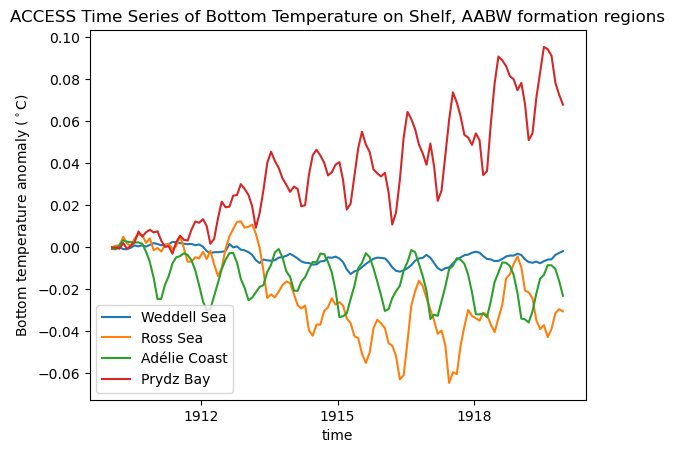

In [37]:
bottemp_anom_W_time.plot(label="Weddell Sea")
bottemp_anom_R_time.plot(label="Ross Sea")
bottemp_anom_A_time.plot(label="Adélie Coast")
bottemp_anom_P_time.plot(label="Prydz Bay")
plt.ylabel("Bottom temperature anomaly ($^\circ$C)")
plt.legend(loc="lower left")
plt.title("ACCESS Time Series of Bottom Temperature on Shelf, AABW formation regions")